# Simple Vectorfield Model

*mZargham*

Demonstration of hyperbolic coordinates and vectorfield interpretation of constant product market maker activity

In [1]:
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
MONTE_CARLO_RUNS = 1
SIMULATION_TIMESTEPS = 100


In [3]:
x0 = 20
y0 = 100

#cartersian to hyperbolic
def xy2uv(x,y):

    u = np.log(np.sqrt(x/y))
    v = np.sqrt(x*y)

    return (u,v)

#hyperbolic to cartesian
def uv2xy(u,v):

    x = v*np.exp(u)
    y = v*np.exp(-u)

    return (x,y)

u0, v0 = xy2uv(x0,y0)

genesis_states = {
    'cartesian': (x0,y0),
    'hyperbolic': (u0,v0)
}

This snippet is intended to demonstrate the impact of latent market forces on an AMM using a simple vectorfield representation.

For simplicity we will construct a simple vector field around an equilibrium characterized by $P(x,y) = \frac{x}{y} = P^*$.

While our market is characterized by Quadrant I of the Cartesian plane, we are working with the idealized constant product market maker so there is an invariant function $V(x,y) = x \cdot y = V^*$

The resulting dynamical system can be expressed succinctly in hyperbolic coordinates

$u = \ln \sqrt{\frac{x}{y}} = \ln \sqrt{P(x,y)}$

$v = \sqrt{x\cdot y} = \sqrt{V(x,y)}$

By excluding the add/remove liquidity mechanism we can characterize the vectorfield using only the $u$ dimension as fixed at $v = v_0 = \sqrt{V^*}$

$\Delta u = -k(u-u^*)$

$\Delta {v} = 0$ 

where $u^* = \ln \sqrt{P^*}$ and $k$ is gain coeficient.

we can construct a vectorfield representation of this in cartesian coordinates as follows



In [4]:
# vectorfield
k=.5
pstar = 1
ustar = np.log(np.sqrt(pstar))

x,y = np.meshgrid(np.linspace(1,2001,21),np.linspace(1,2001,21))

u, v = xy2uv(x,y)

du = -k*(u-ustar)
dv = np.zeros_like(v)

xplus, yplus = uv2xy(u+du,v+dv)
dx = (xplus-x)
dy = (yplus-y)



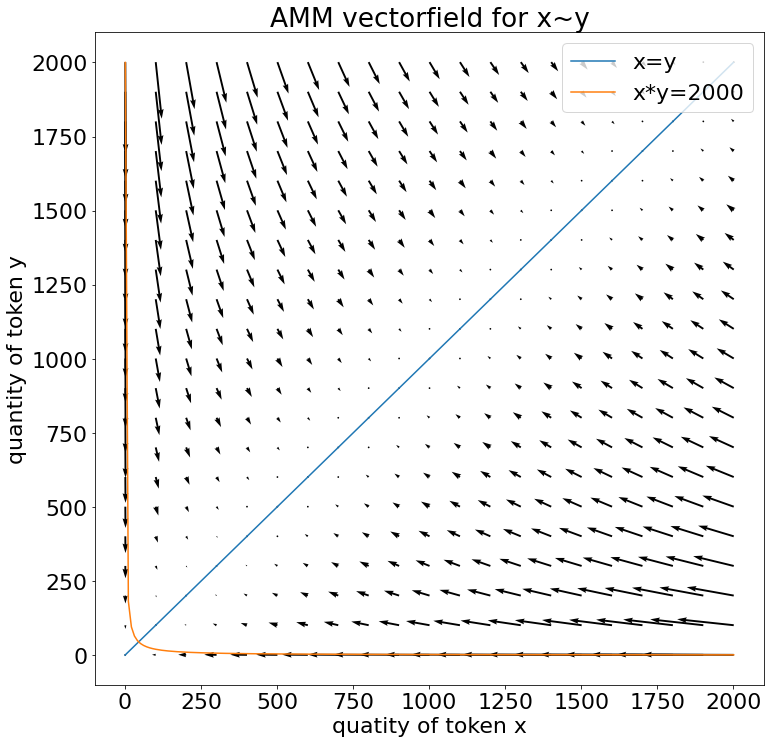

In [5]:
plt.rcParams.update({'font.size': 22})

plt.xlabel('quatity of token x')
plt.ylabel('quantity of token y')
plt.plot([0,2000], [0,2000], np.linspace(1,2001, 201), 2000/np.linspace(1,2001, 201))
plt.legend(["x=y", "x*y=2000"])
plt.quiver(x,y,dx,dy)
plt.title('AMM vectorfield for x~y')


f = plt.gcf()
f.set_figwidth(12)
f.set_figheight(12)

In [6]:

def applyField(params, 
                substep, 
                state_history, 
                prev_state):
    pstar = params['pstar']
    ustar = np.log(np.sqrt(pstar))
    
    u, __ = prev_state['hyperbolic']
    error = u-ustar

    du = -params['field']*error + params['noise']*np.random.randn()

    return {'du':du}

In [7]:
def update_hyperbolic(params, 
                substep, 
                state_history, 
                prev_state, 
                policy_input):
    u, v = prev_state['hyperbolic']
    u = u+policy_input['du']
    point = (u, v)

    return ('hyperbolic', point)

def update_cartesian(params, 
                substep, 
                state_history, 
                prev_state, 
                policy_input):
    u, v = prev_state['hyperbolic']
    u = u+policy_input['du']

    x,y = uv2xy(u,v)
    point = (x, y)

    return ('cartesian', point)

In [8]:

sys_params = {
    'pstar': [1],
    'field': [.25],
    'noise' : [.05]
}


In [9]:

partial_state_update_blocks = [
    {
        'policies': {applyField
            
        },
        'variables': {
            'cartesian': update_cartesian,
            'hyperbolic': update_hyperbolic
        }
    }
]

sim_config = {
    'N': MONTE_CARLO_RUNS,
    'T': range(SIMULATION_TIMESTEPS),
    'M': sys_params
}

In [10]:
sim_params = config_sim(sim_config)
print(sim_params)

[{'N': 1, 'T': range(0, 100), 'M': {'pstar': 1, 'field': 0.25, 'noise': 0.05}}]


In [11]:
exp = Experiment()
exp.append_configs(
    sim_configs=sim_params,
    initial_state=genesis_states,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

In [12]:
from importlib.metadata import version
print(version('cadCAD'))

0.4.28


In [13]:
# from cadCAD import configs

simulation = Executor(exec_context=local_mode_ctx,
                      configs=exp.configs)
raw_system_events, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 3, 1, 2)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 3, 1, 2)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 0.01s


In [14]:
df = pd.DataFrame(raw_system_events)
df.head()

,cartesian,hyperbolic,simulation,subset,run,substep,timestep
0,"(20, 100)","(-0.8047189562170503, 44.721359549995796)",0,0,1,0,0
1,"(22.977906588130452, 87.04013102016557)","(-0.665918058622287, 44.721359549995796)",0,0,1,1,1
2,"(26.56792845046667, 75.27873329412213)","(-0.5207464387720878, 44.721359549995796)",0,0,1,1,2
3,"(29.425140955669367, 67.96908816896112)","(-0.4186017862990677, 44.721359549995796)",0,0,1,1,3
4,"(32.6702524312793, 61.217770025099384)","(-0.3139862774882101, 44.721359549995796)",0,0,1,1,4


In [15]:
df['x'] = df.cartesian.apply(lambda z: z[0])
df['y'] = df.cartesian.apply(lambda z: z[1])
df['dx']= df.x.diff()
df['dy']= df.y.diff()

Text(0, 0.5, 'y')

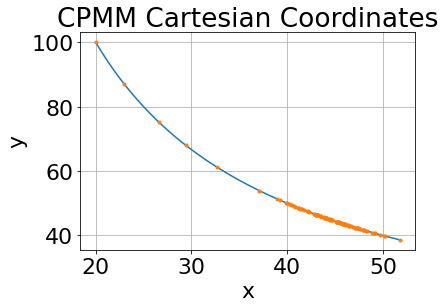

In [16]:
plt.plot(np.linspace(df.x.min(),df.x.max(), 101), x0*y0/np.linspace(df.x.min(),df.x.max(),101))
plt.plot(df.x,df.y, '.')
plt.grid('square')
plt.title("CPMM Cartesian Coordinates")
plt.xlabel('x')
plt.ylabel('y')

In [17]:
df['u'] = df.hyperbolic.apply(lambda z: z[0])
df['v'] = df.hyperbolic.apply(lambda z: z[1])
df['du']= df.u.diff()
df['dv']= df.v.diff()

Text(0, 0.5, 'v')

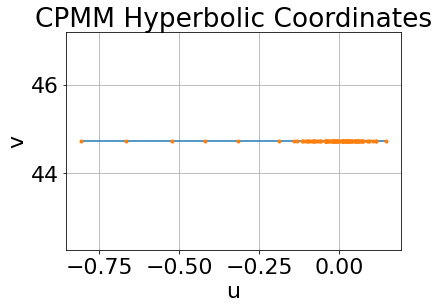

In [18]:
plt.plot(np.linspace(df.u.min(),df.u.max(), 101), v0*np.ones_like(np.linspace(df.u.min(),df.u.max(), 101)))
plt.plot(df.u,df.v, '.')
plt.grid('square')
plt.title("CPMM Hyperbolic Coordinates")
plt.xlabel('u')
plt.ylabel('v')

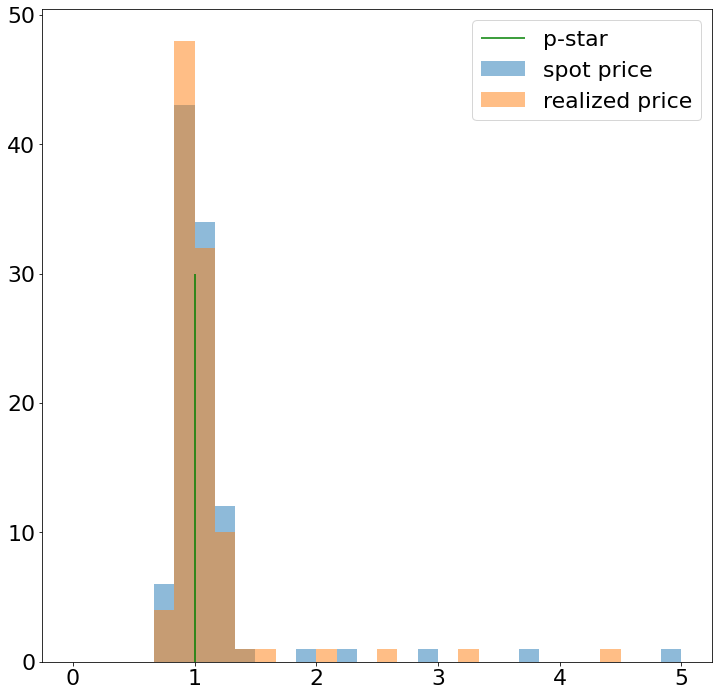

In [19]:
plt.hist(df.y/df.x, bins=np.linspace(0,5,31), alpha=.5)
plt.hist(-df.y.diff()/df.x.diff(), bins=np.linspace(0,5,31), alpha=.5)
plt.vlines(1,0,30, 'g')
f = plt.gcf()
f.set_figwidth(12)
f.set_figheight(12)
plt.legend(["p-star", "spot price", "realized price"])

Text(0.5, 0, 'index')

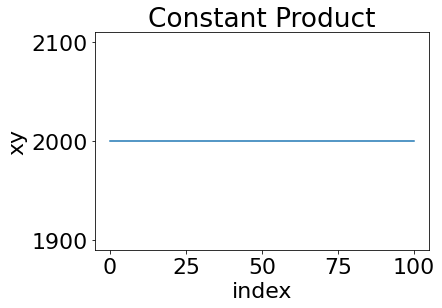

In [20]:
plt.plot(df.index,df.x*df.y)
plt.title("Constant Product")
plt.ylabel("xy")
plt.xlabel("index")

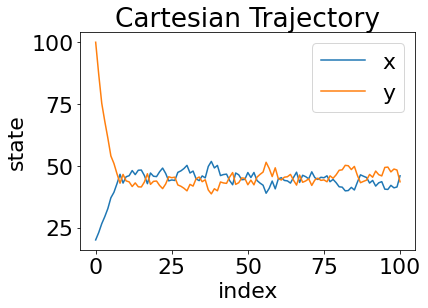

In [21]:
plt.plot(df.index,df.x, df.index, df.y)
plt.title("Cartesian Trajectory")
plt.ylabel("state")
plt.xlabel("index")
plt.legend(["x", "y"])

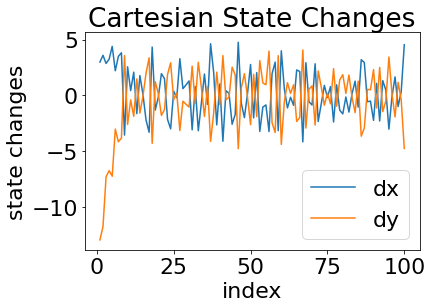

In [22]:
plt.plot(df.index,df.dx, df.index, df.dy)
plt.title("Cartesian State Changes")
plt.ylabel("state changes")
plt.xlabel("index")
plt.legend(["dx", "dy"])

Text(0, 0.5, 'v')

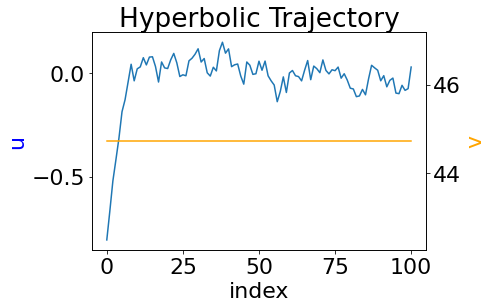

In [23]:
plt.plot(df.index,df.u)
ax1=plt.gca()
plt.xlabel("index")
ax2 = ax1.twinx()
ax2.plot(df.index, df.v, 'orange')
plt.title("Hyperbolic Trajectory")

ax1.set_ylabel('u', color='b')
ax2.set_ylabel('v', color='orange')

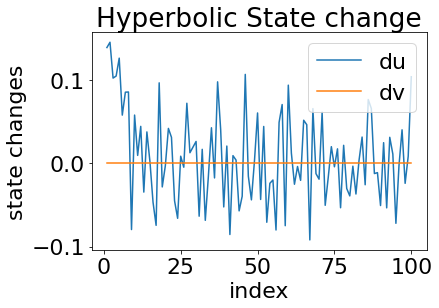

In [24]:
plt.plot(df.index,df.du, df.index, df.dv)
plt.title("Hyperbolic State change")
plt.ylabel("state changes")
plt.xlabel("index")
plt.legend(["du", "dv"])